In [9]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
# Date Functionality
import matplotlib.dates as mdates
from matplotlib.dates import DateFormatter

# Statistical analysis
from scipy.stats import ttest_ind


# Remove Warnings
import warnings
warnings.filterwarnings("ignore")

In [10]:
purchase = pd.read_csv('QVI_purchase_behaviour.csv')
transaction = pd.read_excel('QVI_transaction_data.xlsx')

In [11]:
purchase.head()

,LYLTY_CARD_NBR,LIFESTAGE,PREMIUM_CUSTOMER
0,1000,YOUNG SINGLES/COUPLES,Premium
1,1002,YOUNG SINGLES/COUPLES,Mainstream
2,1003,YOUNG FAMILIES,Budget
3,1004,OLDER SINGLES/COUPLES,Mainstream
4,1005,MIDAGE SINGLES/COUPLES,Mainstream


In [12]:
transaction.head()

,DATE,STORE_NBR,LYLTY_CARD_NBR,TXN_ID,PROD_NBR,PROD_NAME,PROD_QTY,TOT_SALES
0,43390,1,1000,1,5,Natural Chip Compny SeaSalt175g,2,6.0
1,43599,1,1307,348,66,CCs Nacho Cheese 175g,3,6.3
2,43605,1,1343,383,61,Smiths Crinkle Cut Chips Chicken 170g,2,2.9
3,43329,2,2373,974,69,Smiths Chip Thinly S/Cream&Onion 175g,5,15.0
4,43330,2,2426,1038,108,Kettle Tortilla ChpsHny&Jlpno Chili 150g,3,13.8


In [13]:
# MERGING BOTH DATASETS IN PREPARATION FOR ANALYSIS

data = pd.merge(transaction, purchase, on='LYLTY_CARD_NBR', how='inner')

In [14]:
data.head()

,DATE,STORE_NBR,LYLTY_CARD_NBR,TXN_ID,PROD_NBR,PROD_NAME,PROD_QTY,TOT_SALES,LIFESTAGE,PREMIUM_CUSTOMER
0,43390,1,1000,1,5,Natural Chip Compny SeaSalt175g,2,6.0,YOUNG SINGLES/COUPLES,Premium
1,43599,1,1307,348,66,CCs Nacho Cheese 175g,3,6.3,MIDAGE SINGLES/COUPLES,Budget
2,43414,1,1307,346,96,WW Original Stacked Chips 160g,2,3.8,MIDAGE SINGLES/COUPLES,Budget
3,43533,1,1307,347,54,CCs Original 175g,1,2.1,MIDAGE SINGLES/COUPLES,Budget
4,43605,1,1343,383,61,Smiths Crinkle Cut Chips Chicken 170g,2,2.9,MIDAGE SINGLES/COUPLES,Budget


In [32]:
data.shape

(264257, 10)

In [15]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 264836 entries, 0 to 264835
Data columns (total 10 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   DATE              264836 non-null  int64  
 1   STORE_NBR         264836 non-null  int64  
 2   LYLTY_CARD_NBR    264836 non-null  int64  
 3   TXN_ID            264836 non-null  int64  
 4   PROD_NBR          264836 non-null  int64  
 5   PROD_NAME         264836 non-null  object 
 6   PROD_QTY          264836 non-null  int64  
 7   TOT_SALES         264836 non-null  float64
 8   LIFESTAGE         264836 non-null  object 
 9   PREMIUM_CUSTOMER  264836 non-null  object 
dtypes: float64(1), int64(6), object(3)
memory usage: 22.2+ MB


In [17]:
# Convert Date column into DATE format
origin = pd.Timestamp("30/12/1899")
data["DATE"] = data["DATE"].apply(lambda x: origin + pd.Timedelta(days=x))
data



TypeError: Invalid type <class 'pandas._libs.tslibs.timestamps.Timestamp'>. Must be int or float.

In [19]:
data.isnull().sum()

DATE                0
STORE_NBR           0
LYLTY_CARD_NBR      0
TXN_ID              0
PROD_NBR            0
PROD_NAME           0
PROD_QTY            0
TOT_SALES           0
LIFESTAGE           0
PREMIUM_CUSTOMER    0
dtype: int64

In [20]:
# Checking for duplicates
data.duplicated().sum()

1

In [23]:
# Dropping dupliacte values
data.drop_duplicates(inplace=True)

In [25]:
# Checking Categorical and Numerical Variables available in dataset

data_numerics_only = data.select_dtypes(include=np.number)
data_cat = set(data.columns) - set(data_numerics_only)
print("Numeric Columns:\n",list(data_numerics_only))
print("Categorical Columns:\n",list(data_cat))

Numeric Columns:
 ['STORE_NBR', 'LYLTY_CARD_NBR', 'TXN_ID', 'PROD_NBR', 'PROD_QTY', 'TOT_SALES']
Categorical Columns:
 ['DATE', 'LIFESTAGE', 'PREMIUM_CUSTOMER', 'PROD_NAME']


In [37]:
data.describe()

,STORE_NBR,LYLTY_CARD_NBR,TXN_ID,PROD_NBR,PROD_QTY,TOT_SALES
count,246203.00000,2.462030e+05,2.462030e+05,246203.000000,246203.000000,246203.000000
mean,135.04716,1.355277e+05,1.351275e+05,56.359102,1.900862,7.289269
std,76.78963,8.072610e+04,7.815044e+04,33.693119,0.319614,2.403628
min,1.00000,1.000000e+03,1.000000e+00,1.000000,1.000000,1.700000
25%,70.00000,7.001500e+04,6.756450e+04,26.000000,2.000000,5.800000
50%,130.00000,1.303670e+05,1.351820e+05,53.000000,2.000000,7.400000
75%,203.00000,2.030830e+05,2.026515e+05,87.000000,2.000000,8.800000
max,272.00000,2.373711e+06,2.415841e+06,114.000000,5.000000,14.800000


In [26]:
# Checking and removing outliers

def remove_outlier_IQR(df):
    Q1=df.quantile(0.25)
    Q3=df.quantile(0.75)
    IQR=Q3-Q1
    df_final=df[~((df<(Q1-1.5*IQR)) | (df>(Q3+1.5*IQR)))]
    return df_final

Text(0, 0.5, 'Total Sales)')

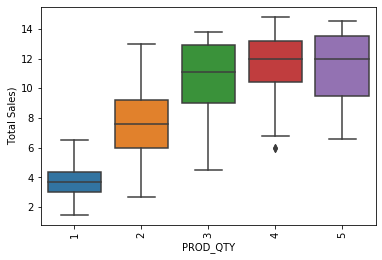

In [29]:
df_outlier_removed=remove_outlier_IQR(data.TOT_SALES)
df_outlier_removed=pd.DataFrame(df_outlier_removed)
ind_diff=data.index.difference(df_outlier_removed.index)

for i in range(0, len(ind_diff),1):
    df_final=data.drop([ind_diff[i]])
    data =df_final
    
sns.boxplot(y='TOT_SALES', x='PROD_QTY',data=data)
plt.xticks(rotation=90)
plt.ylabel('Total Sales)')


In [31]:
print("Shape of dataset after treating outliers:",data.shape)

Shape of dataset after treating outliers: (264257, 10)


In [33]:
data['PROD_NAME'].value_counts()

Kettle Tortilla ChpsHny&Jlpno Chili 150g    3285
Kettle Mozzarella   Basil & Pesto 175g      3280
Tyrrells Crisps     Ched & Chives 165g      3264
Cobs Popd Swt/Chlli &Sr/Cream Chips 110g    3260
Cobs Popd Sea Salt  Chips 110g              3259
                                            ... 
Woolworths Medium   Salsa 300g              1430
RRD Pc Sea Salt     165g                    1429
French Fries Potato Chips 175g              1418
NCC Sour Cream &    Garden Chives 175g      1416
WW Crinkle Cut      Original 175g           1410
Name: PROD_NAME, Length: 114, dtype: int64

In [34]:
# we require only insights on chips category, removing any other product.
data = data[data["PROD_NAME"].str.contains("Salsa")==False]
data.head()

,DATE,STORE_NBR,LYLTY_CARD_NBR,TXN_ID,PROD_NBR,PROD_NAME,PROD_QTY,TOT_SALES,LIFESTAGE,PREMIUM_CUSTOMER
0,2018-10-17,1,1000,1,5,Natural Chip Compny SeaSalt175g,2,6.0,YOUNG SINGLES/COUPLES,Premium
1,2019-05-14,1,1307,348,66,CCs Nacho Cheese 175g,3,6.3,MIDAGE SINGLES/COUPLES,Budget
2,2018-11-10,1,1307,346,96,WW Original Stacked Chips 160g,2,3.8,MIDAGE SINGLES/COUPLES,Budget
3,2019-03-09,1,1307,347,54,CCs Original 175g,1,2.1,MIDAGE SINGLES/COUPLES,Budget
4,2019-05-20,1,1343,383,61,Smiths Crinkle Cut Chips Chicken 170g,2,2.9,MIDAGE SINGLES/COUPLES,Budget


In [35]:
data['PROD_NAME'].value_counts()

Kettle Tortilla ChpsHny&Jlpno Chili 150g    3285
Kettle Mozzarella   Basil & Pesto 175g      3280
Tyrrells Crisps     Ched & Chives 165g      3264
Cobs Popd Swt/Chlli &Sr/Cream Chips 110g    3260
Cobs Popd Sea Salt  Chips 110g              3259
                                            ... 
Sunbites Whlegrn    Crisps Frch/Onin 90g    1432
RRD Pc Sea Salt     165g                    1429
French Fries Potato Chips 175g              1418
NCC Sour Cream &    Garden Chives 175g      1416
WW Crinkle Cut      Original 175g           1410
Name: PROD_NAME, Length: 105, dtype: int64

In [36]:
data.describe()

,STORE_NBR,LYLTY_CARD_NBR,TXN_ID,PROD_NBR,PROD_QTY,TOT_SALES
count,246203.00000,2.462030e+05,2.462030e+05,246203.000000,246203.000000,246203.000000
mean,135.04716,1.355277e+05,1.351275e+05,56.359102,1.900862,7.289269
std,76.78963,8.072610e+04,7.815044e+04,33.693119,0.319614,2.403628
min,1.00000,1.000000e+03,1.000000e+00,1.000000,1.000000,1.700000
25%,70.00000,7.001500e+04,6.756450e+04,26.000000,2.000000,5.800000
50%,130.00000,1.303670e+05,1.351820e+05,53.000000,2.000000,7.400000
75%,203.00000,2.030830e+05,2.026515e+05,87.000000,2.000000,8.800000
max,272.00000,2.373711e+06,2.415841e+06,114.000000,5.000000,14.800000


In [38]:
# Extracting pack size from the Product
import re
def find_number(text):
    num = re.findall(r'[0-9]+',text)
    return " ".join(num)
data['pack_size']=data['PROD_NAME'].apply(lambda x: find_number(x))
data.head()


,DATE,STORE_NBR,LYLTY_CARD_NBR,TXN_ID,PROD_NBR,PROD_NAME,PROD_QTY,TOT_SALES,LIFESTAGE,PREMIUM_CUSTOMER,pack_size
0,2018-10-17,1,1000,1,5,Natural Chip Compny SeaSalt175g,2,6.0,YOUNG SINGLES/COUPLES,Premium,175
1,2019-05-14,1,1307,348,66,CCs Nacho Cheese 175g,3,6.3,MIDAGE SINGLES/COUPLES,Budget,175
2,2018-11-10,1,1307,346,96,WW Original Stacked Chips 160g,2,3.8,MIDAGE SINGLES/COUPLES,Budget,160
3,2019-03-09,1,1307,347,54,CCs Original 175g,1,2.1,MIDAGE SINGLES/COUPLES,Budget,175
4,2019-05-20,1,1343,383,61,Smiths Crinkle Cut Chips Chicken 170g,2,2.9,MIDAGE SINGLES/COUPLES,Budget,170
...,...,...,...,...,...,...,...,...,...,...,...
264831,2019-03-09,272,272319,270088,89,Kettle Sweet Chilli And Sour Cream 175g,2,10.8,YOUNG SINGLES/COUPLES,Premium,175
264832,2018-08-13,272,272358,270154,74,Tostitos Splash Of Lime 175g,1,4.4,YOUNG SINGLES/COUPLES,Premium,175
264833,2018-11-06,272,272379,270187,51,Doritos Mexicana 170g,2,8.8,YOUNG SINGLES/COUPLES,Premium,170
264834,2018-12-27,272,272379,270188,42,Doritos Corn Chip Mexican Jalapeno 150g,2,7.8,YOUNG SINGLES/COUPLES,Premium,150


In [61]:
#Creating column for brand name

data['BRAND']=[s.split()[0] for s in data['PROD_NAME']]
data['BRAND'].replace('Dorito','Doritos',inplace=True)
data['BRAND'].replace('Infzns','Infuzions',inplace=True)
data['BRAND'].replace('Smith','Smiths',inplace=True)
data['BRAND'].replace('Snbts','Sunbites',inplace=True)
data['BRAND'].replace('Red','RRD',inplace=True)
data['BRAND'].replace('Old','Old El Paso',inplace=True)
data['BRAND'].replace('WW','Woolworths',inplace=True)
data['BRAND'].replace('Natural','NCC',inplace=True)

data.head()

,DATE,STORE_NBR,LYLTY_CARD_NBR,TXN_ID,PROD_NBR,PROD_NAME,PROD_QTY,TOT_SALES,LIFESTAGE,PREMIUM_CUSTOMER,pack_size,BRAND
0,2018-10-17,1,1000,1,5,Natural Chip Compny SeaSalt175g,2,6.0,YOUNG SINGLES/COUPLES,Premium,175,NCC
1,2019-05-14,1,1307,348,66,CCs Nacho Cheese 175g,3,6.3,MIDAGE SINGLES/COUPLES,Budget,175,CCs
2,2018-11-10,1,1307,346,96,WW Original Stacked Chips 160g,2,3.8,MIDAGE SINGLES/COUPLES,Budget,160,Woolworths
3,2019-03-09,1,1307,347,54,CCs Original 175g,1,2.1,MIDAGE SINGLES/COUPLES,Budget,175,CCs
4,2019-05-20,1,1343,383,61,Smiths Crinkle Cut Chips Chicken 170g,2,2.9,MIDAGE SINGLES/COUPLES,Budget,170,Smiths


In [62]:
data["BRAND"].value_counts()

Kettle        41141
Smiths        30302
Doritos       25150
Pringles      25052
RRD           16307
Infuzions     14173
Thins         14049
Woolworths    11836
Cobs           9669
Tostitos       9443
Twisties       9420
NCC            7453
Tyrrells       6428
Grain          6265
Cheezels       4583
CCs            4551
Sunbites       3008
Cheetos        2926
Burger         1564
GrnWves        1465
French         1418
Name: BRAND, dtype: int64

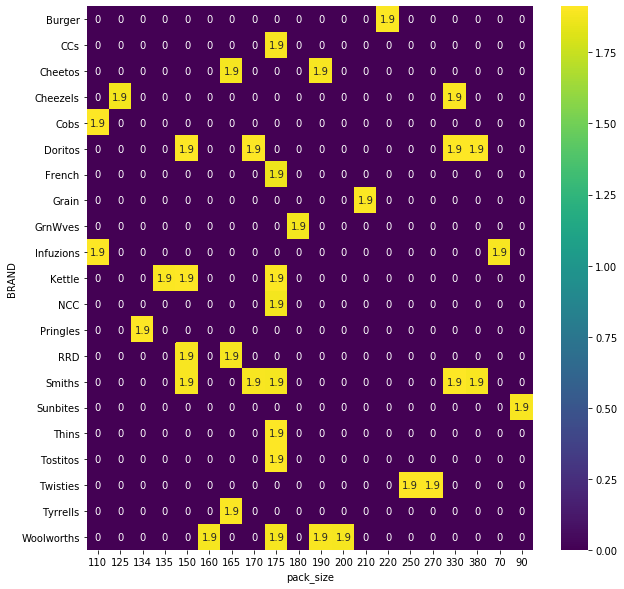

In [58]:
#heatmap showing packet quantity mostly bought according to brand and packet size
plt.figure(figsize=(10,10))
sns.heatmap(pd.pivot_table(data=data,index='BRAND',columns='pack_size',values='PROD_QTY').fillna(0),cmap='viridis',
            annot = True, annot_kws={'size':10})


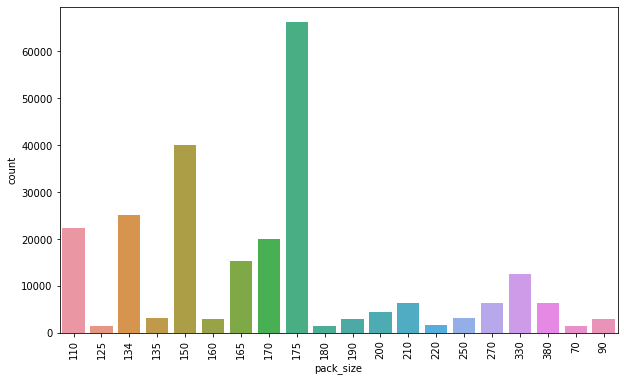

In [60]:
#histogram of count packet size
plt.figure(figsize=(10,6))
plt.xticks(rotation=90)
sns.countplot(data['pack_size'])

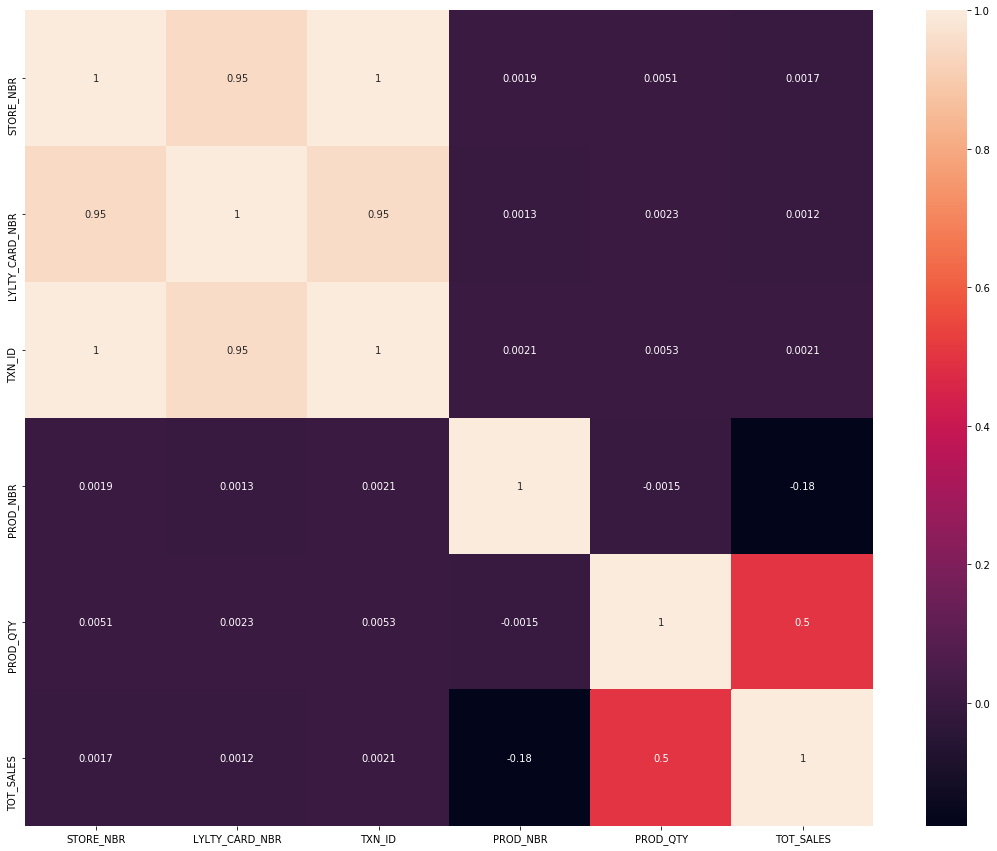

In [65]:
correlation = data.corr()
# Plot correlation
plt.figure(figsize=(19,15))
sns.heatmap(correlation, xticklabels=correlation.columns.values,
 yticklabels=correlation.columns.values, annot = True, annot_kws={'size':10})
# Axis ticks size
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.show()

In [64]:
# Checking for missing dates
pd.date_range(start = '2018-07-01', end = '2019-06-30').difference(data['DATE'])

DatetimeIndex(['2018-12-25'], dtype='datetime64[ns]', freq=None)

### Missing date on christmas, probably store was closed for the holidays

In [69]:
# Create a new dataframe which contains the total sale for each date

sales_per_day = pd.pivot_table(data, values = 'TOT_SALES', index = 'DATE', aggfunc = 'sum')
sales_per_day.head()


,TOT_SALES
DATE,
2018-07-01,4920.1
2018-07-02,4877.0
2018-07-03,4954.7
2018-07-04,4968.1
2018-07-05,4682.0


In [76]:
"""""""""
timeline = sales_per_day.index
graph = data['TOT_SALES']



fig, ax = plt.subplots(figsize = (15, 5), linewidth=5, edgecolor="#04253a", facecolor = '#e1ddbf')

ax.plot(timeline, graph)

ax.set_facecolor("red")

date_form = DateFormatter("%Y-%m")
ax.xaxis.set_major_formatter(date_form)
plt.title('Total Sales from July 2018 to June 2019')
plt.xlabel('Time')
plt.ylabel('TOT_SALES')
"""""""

SyntaxError: EOF while scanning triple-quoted string literal (<ipython-input-76-4297efa62093>, line 18)

In [77]:
data['LIFESTAGE'].value_counts()

OLDER SINGLES/COUPLES     50676
RETIREES                  46342
OLDER FAMILIES            45042
YOUNG FAMILIES            40395
YOUNG SINGLES/COUPLES     33917
MIDAGE SINGLES/COUPLES    23342
NEW FAMILIES               6489
Name: LIFESTAGE, dtype: int64

In [78]:
data['PREMIUM_CUSTOMER'].value_counts()

Mainstream    94839
Budget        86567
Premium       64797
Name: PREMIUM_CUSTOMER, dtype: int64

<Figure size 432x288 with 0 Axes>

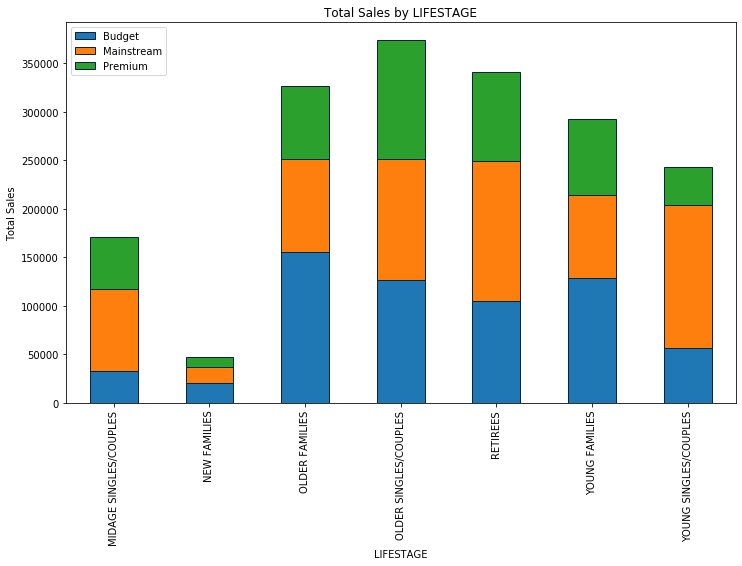

In [80]:
G1= pd.DataFrame(data.groupby(['LIFESTAGE', 'PREMIUM_CUSTOMER']).TOT_SALES.sum())

fig = plt.figure(linewidth=5, edgecolor="#04253a", facecolor = '#e1ddbf')

G1.unstack().plot(kind = 'bar', stacked = True, figsize = (12, 7), title = 'Total Sales by LIFESTAGE' , edgecolor="#04253a")

plt.ylabel('Total Sales')
plt.legend(['Budget', 'Mainstream', 'Premium'], loc = 2)

In [83]:
G2 = pd.DataFrame(data.groupby(['PREMIUM_CUSTOMER', 'LIFESTAGE']).LYLTY_CARD_NBR.nunique())
G2.rename(columns = {'LYLTY_CARD_NBR': 'Number of Customers'}, inplace = True)
G2 = G2.sort_values(by = 'Number of Customers', ascending = False).head(20)
G2


Number of Customers
PREMIUM_CUSTOMER LIFESTAGE                                  
Mainstream       YOUNG SINGLES/COUPLES                  7905
                 RETIREES                               6357
                 OLDER SINGLES/COUPLES                  4853
Budget           OLDER SINGLES/COUPLES                  4846
Premium          OLDER SINGLES/COUPLES                  4681
Budget           OLDER FAMILIES                         4606
                 RETIREES                               4382
                 YOUNG FAMILIES                         3951
Premium          RETIREES                               3811
Budget           YOUNG SINGLES/COUPLES                  3644
Mainstream       MIDAGE SINGLES/COUPLES                 3294
                 OLDER FAMILIES                         2788
                 YOUNG FAMILIES                         2683
Premium          YOUNG SINGLES/COUPLES                  2479
                 YOUNG FAMILIES                         2397
                 MIDAGE SINGLES/COUPLES                 2369
                 OLDER FAMILIES                         2230
Budget           MIDAGE SINGLES/COUPLES                 1472
                 NEW FAMILIES                           1087
Mainstream       NEW FAMILIES                            830

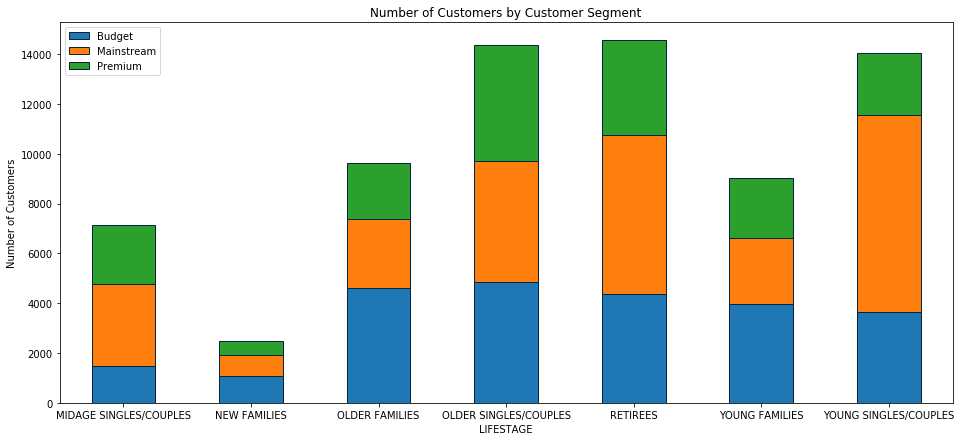

In [86]:
G2 = pd.DataFrame(data.groupby(['LIFESTAGE', 'PREMIUM_CUSTOMER']).LYLTY_CARD_NBR.nunique())
G2.unstack().plot(kind='bar', stacked = True , rot=0 , figsize = (16, 7), title = 'Number of Customers by Customer Segment',  edgecolor="#04253a")
plt.ylabel('Number of Customers')
plt.legend(['Budget', 'Mainstream', 'Premium'], loc = 2)

In [89]:
# Perform an independent t-test between mainstream vs non-mainstream midage and young singles/couples to test this difference

# Create a new dataframe pricePerUnit
d1 = data.copy()

# Create a new column under pricePerUnit called PRICE
d1['PRICE'] = d1['TOT_SALES'] / d1['PROD_QTY']

# Let's have a look
d1.head()

,DATE,STORE_NBR,LYLTY_CARD_NBR,TXN_ID,PROD_NBR,PROD_NAME,PROD_QTY,TOT_SALES,LIFESTAGE,PREMIUM_CUSTOMER,pack_size,BRAND,PRICE
0,2018-10-17,1,1000,1,5,Natural Chip Compny SeaSalt175g,2,6.0,YOUNG SINGLES/COUPLES,Premium,175,NCC,3.00
1,2019-05-14,1,1307,348,66,CCs Nacho Cheese 175g,3,6.3,MIDAGE SINGLES/COUPLES,Budget,175,CCs,2.10
2,2018-11-10,1,1307,346,96,WW Original Stacked Chips 160g,2,3.8,MIDAGE SINGLES/COUPLES,Budget,160,Woolworths,1.90
3,2019-03-09,1,1307,347,54,CCs Original 175g,1,2.1,MIDAGE SINGLES/COUPLES,Budget,175,CCs,2.10
4,2019-05-20,1,1343,383,61,Smiths Crinkle Cut Chips Chicken 170g,2,2.9,MIDAGE SINGLES/COUPLES,Budget,170,Smiths,1.45


In [102]:
# What's the average chip price by customer segment
d1['CHIP_PRICE']=d1['TOT_SALES']/d1['PROD_QTY']
G3=d1[['LIFESTAGE','PREMIUM_CUSTOMER','CHIP_PRICE']].groupby(['PREMIUM_CUSTOMER','LIFESTAGE']).mean()
G3.sort_values("CHIP_PRICE",ascending=False)

CHIP_PRICE
PREMIUM_CUSTOMER LIFESTAGE                         
Mainstream       YOUNG SINGLES/COUPLES     4.064780
                 MIDAGE SINGLES/COUPLES    3.992712
Budget           RETIREES                  3.922498
Premium          RETIREES                  3.919553
Budget           NEW FAMILIES              3.916395
Mainstream       NEW FAMILIES              3.916178
Premium          OLDER SINGLES/COUPLES     3.891497
Budget           OLDER SINGLES/COUPLES     3.880165
Premium          NEW FAMILIES              3.871265
Mainstream       RETIREES                  3.843470
                 OLDER SINGLES/COUPLES     3.812741
Premium          MIDAGE SINGLES/COUPLES    3.769333
                 YOUNG FAMILIES            3.761270
Budget           YOUNG FAMILIES            3.759533
                 OLDER FAMILIES            3.743303
                 MIDAGE SINGLES/COUPLES    3.742596
Mainstream       OLDER FAMILIES            3.735501
                 YOUNG FAMILIES            3.722813
Premium          OLDER FAMILIES            3.715825
                 YOUNG SINGLES/COUPLES     3.665167
Budget           YOUNG SINGLES/COUPLES     3.656931

# Observation

Customers who considerily pay more for chips are Mainstream Young Singles/Couples and Mainstream Midage Singles and Couples

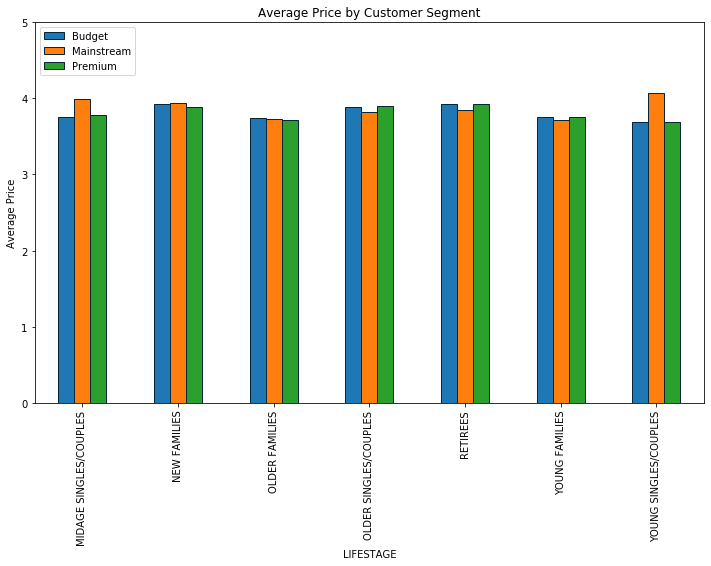

In [109]:
G3 = pd.DataFrame(d1.groupby(['LIFESTAGE', 'PREMIUM_CUSTOMER']).TOT_SALES.sum() / d1.groupby(['LIFESTAGE', 'PREMIUM_CUSTOMER']).PROD_QTY.sum())
G3.unstack().plot(kind = 'bar', figsize = (12, 7), title = 'Average Price by Customer Segment', ylim = (0, 5),  edgecolor="#04253a")
plt.ylabel('Average Price')
plt.legend(['Budget', 'Mainstream', 'Premium'], loc = 2)

In [104]:
d1['LIFESTAGE'].value_counts()

OLDER SINGLES/COUPLES     50676
RETIREES                  46342
OLDER FAMILIES            45042
YOUNG FAMILIES            40395
YOUNG SINGLES/COUPLES     33917
MIDAGE SINGLES/COUPLES    23342
NEW FAMILIES               6489
Name: LIFESTAGE, dtype: int64

In [106]:
# Let's group our data into mainstream and non-mainstream

mainstream = d1.loc[(d1['PREMIUM_CUSTOMER'] == 'Mainstream') & ( (d1['LIFESTAGE'] == 'YOUNG SINGLES/COUPLES') | (d1['LIFESTAGE'] == 'MIDAGE SINGLES/COUPLES') ), 'PRICE']
nonMainstream = d1.loc[(d1['PREMIUM_CUSTOMER'] != 'Mainstream') & ( (d1['LIFESTAGE'] == 'YOUNG SINGLES/COUPLES') | (d1['LIFESTAGE'] == 'MIDAGE SINGLES/COUPLES') ), 'PRICE']
# Perform t-test 

In [107]:
# Perform t-test 

ttest_ind(mainstream, nonMainstream)


Ttest_indResult(statistic=37.752225863415475, pvalue=4.3074270694464924e-308)

## Conclusion

1. Budget – older families, Mainstream – young singles/couples, and Mainstream – retirees shoppers have accounted for the majority of sales.

2. Mainstream young singles/couples and retirees spend more money on chips than other purchasers mainly due to the fact that there are more customers in these segments.

3. Additionally, young, middle-aged, and mainstream individuals and couples are more inclined to pay more for each bag of chips.